In [1]:
import os
import sys

import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from matplotlib import gridspec

get_ipython().magic(u'matplotlib inline')

sys.path.append('../3_analyze')
from containers import Dataset
from score_query import ScoreQuery
from utils import export, show_side_by_side, show_features
from statistics import *
from prob_opt import LigSet, PredictStructs

sys.path.append('../1_dock')
from parse_chembl import load_chembl_raw, load_chembl_proc
from core_proc import load_matches

In [13]:
data = '/scratch/PI/rondror/jbelk/method/data'
glide_dir = 'docking/glide12'
ifp_dir = 'ifp/ifp3'
mcss_dir = 'mcss/mcss1'

struct_dict = {'AR':'2PNU','A2AR':'2YDO','B1AR':'2VT4','B2AR':'2RH1','CHK1':'2BRN', 'PLK1':'2OWB',
               'VITD':'2HB7','BRAF':'3IDP','JAK2':'3KRR','CDK2':'1H1S','ERA':'1A52','GCR':'3K23'}

features = {
    'mcss':[],
    'hbond':[2,3]#,
    #'sb':[4],
    #'pipi':[6],
    #'picat':[7,8],
    #'contact':[11]
}

mcss 1.65971661211


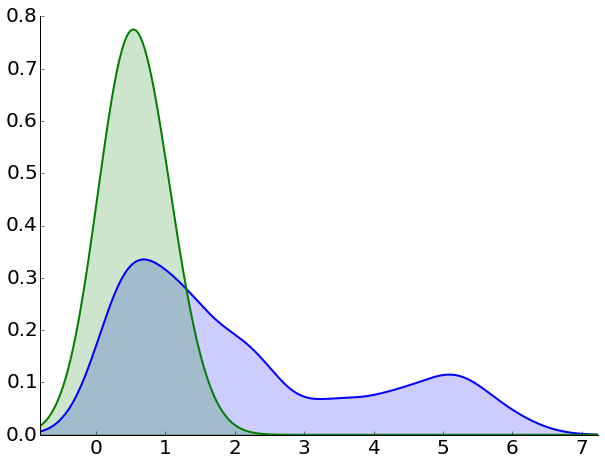

hbond 0.816397363741


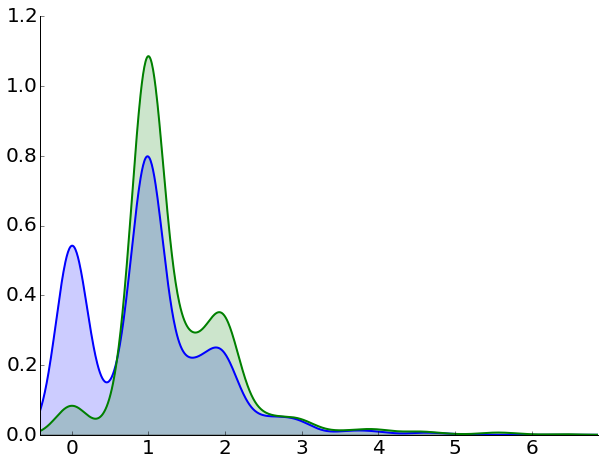

In [14]:
p = 'CHK1'
load_prots = [p]

all_data = Dataset(data, load_prots)

all_data.load_docking(glide_dir, ifp_dir, mcss_dir, structs=struct_dict,
                      load_fp=True, load_crystal=False, load_chembl=False, load_mcss=True)

stats = Statistics(all_data, load_prots, 20, 100, features, 0.25)

for f_name in features.keys():
    print f_name, stats.evidence.std[f_name]
    stats.show_stats(f_name, raw=False, smoothed=True)
    #stats.show_stats_by_pair(f_name, raw=False, smoothed=True)

In [41]:
num_poses = 100
t = 100

for s, st in all_data.proteins[p].docking.items():

    print p, s

    l_list = sorted(st.ligands.keys())[10:20]

    ps = PredictStructs(st, stats.evidence, features, num_poses, t)
    best_cluster, en_landscape = ps.max_posterior(l_list, verbose=True, sampling=1, en_landscape=True)

    ps2 = PredictStructs(st, stats.evidence, {}, num_poses, t)
    best_cluster2, en_landscape2 = ps2.max_posterior(l_list, verbose=False, sampling=1, en_landscape=True)

    us_top = ps.ligset.get_poses(best_cluster)
    glide_top = ps.ligset.get_poses({l:0 for l in best_cluster})
    
    for l in l_list:
        print l, us_top[l].rank, us_top[l].rmsd, 0, glide_top[l].rmsd
    print 'us rmsd:',np.mean([po.rmsd for l,po in us_top.items()])
    print 'phys rmsd:',np.mean([po.rmsd for l,po in glide_top.items()])

CHK1 2BRN
cluster -1, prob = -2138.55240275
cluster 0, prob = -2142.84085579
cluster 1, prob = -2138.32516663
cluster 2, prob = -2138.32516663
cluster 3, prob = -2154.38391743
cluster 4, prob = -2138.32516663
cluster 5, prob = -2154.34703601
cluster 6, prob = -2138.32516663
cluster 7, prob = -2138.32516663
cluster 8, prob = -2138.32516663
cluster 9, prob = -2157.27190993
cluster 10, prob = -2157.22755125
cluster 11, prob = -2138.55240275
cluster 12, prob = -2143.54341378
cluster 13, prob = -2154.39268709
cluster 14, prob = -2138.32516663
2BRO_lig 4 0.734818404183 0 0.464315587809
2C3J_lig 1 0.71179423563 0 1.23514911916
2C3K_lig 5 0.475056188537 0 0.374222694847
2C3L_lig 0 0.712648988288 0 0.712648988288
2CGU_lig 16 2.18328481754 0 3.03514133241
2CGV_lig 2 2.49840039575 0 4.54496463052
2CGW_lig 1 2.3193616087 0 7.55691453261
2CGX_lig 0 2.83510349298 0 2.83510349298
2E9N_lig 2 2.26074001731 0 1.03891601012
2E9O_lig 0 9.34381986394 0 9.34381986394
us rmsd: 2.40750280129
phys rmsd: 3.1141

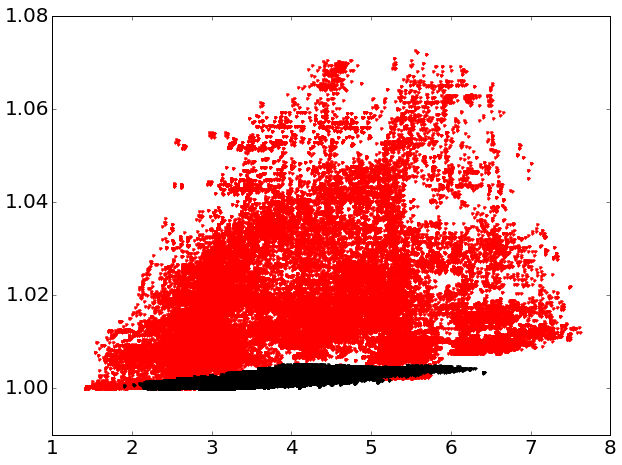

In [42]:
# show energy landscape (score vs rmsd)

norm1 = max([x[0] for x in en_landscape])
objective = [x[0]/norm1 for x in en_landscape]
rmsds = [x[1] for x in en_landscape]
plt.plot(rmsds, objective, 'r.')

norm2 = max([x[0] for x in en_landscape2])
phys_obj = [x[0]/norm2 for x in en_landscape2]
rmsds2 = [x[1] for x in en_landscape2]
plt.plot(rmsds2, phys_obj, 'k.')

#plt.ylim([-1600,-700])
#plt.ylim([0.99,1.05])
plt.show()

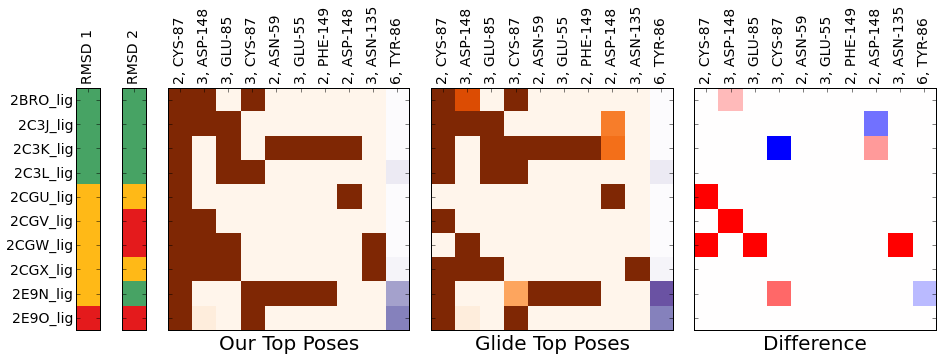

In [43]:
all_data.assign_weights({2:1,3:1,4:1,6:1,11:0.005})

show_side_by_side(us_top, glide_top, l_list, 
                  t1='Our Top Poses', t2='Glide Top Poses', num_i=10, size=1.5)

mcss probability matrix


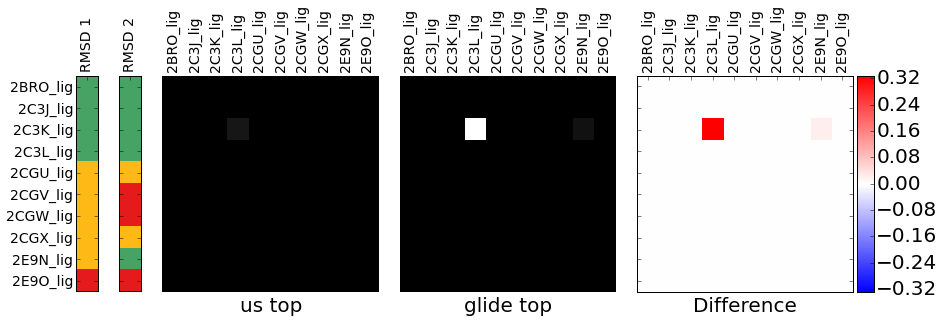

mcss x_k matrix


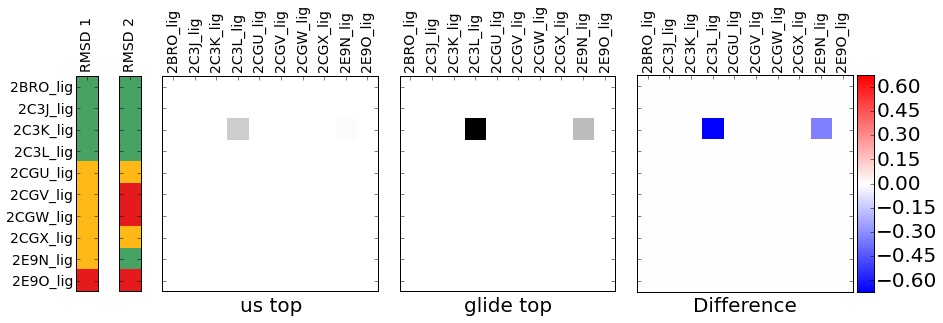

hbond probability matrix


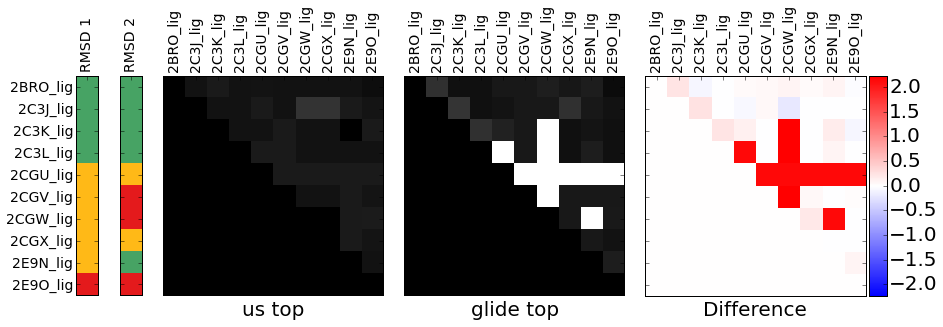

hbond x_k matrix


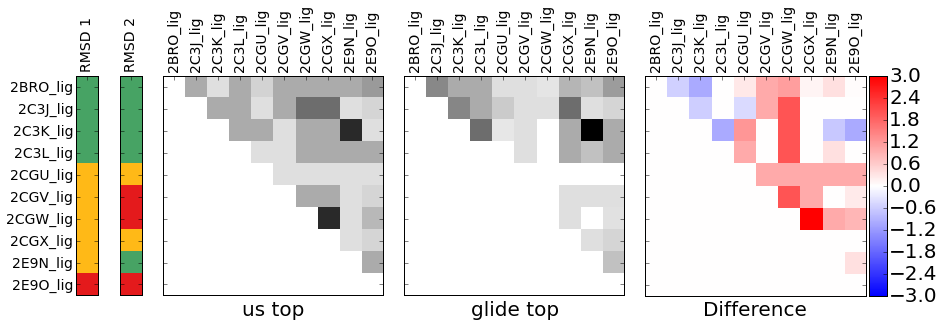

In [44]:
show_prob = True
show_x = True

for k,kdef in features.items():
    x1, log_p1 = ps.x(best_cluster,k,kdef,lig_order=l_list)
    x2, log_p2 = ps.x({l:0 for l in l_list},k,kdef,lig_order=l_list)
    
    if show_prob and np.sum(log_p1) != 0:
        print k, 'probability matrix'
        minval = min(np.min(log_p1[np.nonzero(log_p1)]),np.min(log_p2[np.nonzero(log_p2)]))
        maxval = max(np.max(log_p1[np.nonzero(log_p1)]),np.max(log_p2[np.nonzero(log_p2)]))
        
        show_features(us_top, log_p1, glide_top, log_p2, l_list, 'us top','glide top',size=1.5,mi=minval,ma=maxval)
        
    if show_x:
        print k, 'x_k matrix'
        minval = min(np.min(x1),np.min(x2))
        maxval = max(np.max(x1),np.max(x2))
    
        show_features(us_top, x1, glide_top, x2, l_list, 'us top','glide top',size=1.5,mi=minval,ma=maxval)